<a href="https://colab.research.google.com/github/OuahabAchraf99/Pneumonia_Classification/blob/main/Pneumonia_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Mounting Drive and Downloading DataSet from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%mkdir -p /content/drive/My\ Drive/Pneumonia_Xrays
%cd /content/drive/My Drive/Pneumonia_Xrays

/content/drive/My Drive/Pneumonia_Xrays


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Pneumonia_Xrays"
%pwd

'/content'

In [4]:
!gdown --id '1w0ldWmLkbaypadIDiFexve3bW1IJuosc' --output pneumonia-kaggle.zip 

Downloading...
From: https://drive.google.com/uc?id=1w0ldWmLkbaypadIDiFexve3bW1IJuosc
To: /content/drive/My Drive/Pneumonia_Xrays/pneumonia-kaggle.zip
1.22GB [00:13, 90.8MB/s]


In [5]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Pneumonia_Xrays/pneumonia-kaggle.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/drive/My Drive/Pneumonia_Xrays")
    
%mv pneumonia-kaggle/* ./
%rm pneumonia-kaggle.zip
%rmdir pneumonia-kaggle

In [3]:
%pwd

'/content'

# 2. Loading and Exploring Data

In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
main_path="/content/drive/My Drive/Pneumonia_Xrays/"
IMAGE_SIZE=[180, 180]


In [5]:
Normal_Files=tf.io.gfile.glob(str(main_path+"/train/NORMAL/*"))
Pneumo_Files=tf.io.gfile.glob(str(main_path+"/train/PNEUMONIA/*"))
Nb_Normal,Nb_Pneumo=len(Normal_Files),len(Pneumo_Files)
Nb_Total=Nb_Normal+Nb_Pneumo

print("Nb_Normal=",Nb_Normal,"\nNb_Pneumo= ",Nb_Pneumo)

Nb_Normal= 1341 
Nb_Pneumo=  3875


In [6]:
# Calculate Weights for the Data Imbalance problem since the number of Positifs and Negatifs are not equal

W_Positif= float(Nb_Normal/Nb_Total)
W_Negatif=float(Nb_Pneumo/Nb_Total)
W_Negatif,W_Positif

(0.7429064417177914, 0.2570935582822086)

In [7]:
# Splitting the Data into Training and Testing 
Data=Normal_Files
Data.extend(Pneumo_Files)
Train_Files,Test_Files=train_test_split(Data,test_size=0.2)
print("Training Nb of examples= ",len(Train_Files))
print("Test Nb of examples= ",len(Test_Files))
len(Data)

Training Nb of examples=  4172
Test Nb of examples=  1044


5216

In [8]:
def GetLabel(img_path):
  label=img_path.split("/")
  if(label[-2]=='PNEUMONIA'):
    return 1
  return 0

In [9]:
def DecodeImg(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

In [10]:
def ProcessImg(img_path):
    label = GetLabel(img_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(img_path)
    img = DecodeImg(img)
    return img, label

In [11]:
import random
for i in range(5):
  rand=random.randint(0,Nb_Total)
  img,label=ProcessImg(Data[rand])
  print("Image num: ",rand,"\n   Image size: ",img.numpy().shape,"\n   Image Label: ",label,"\n__________________________")


Image num:  3136 
   Image size:  (180, 180, 3) 
   Image Label:  1 
__________________________
Image num:  1364 
   Image size:  (180, 180, 3) 
   Image Label:  1 
__________________________
Image num:  4904 
   Image size:  (180, 180, 3) 
   Image Label:  1 
__________________________
Image num:  818 
   Image size:  (180, 180, 3) 
   Image Label:  0 
__________________________
Image num:  4049 
   Image size:  (180, 180, 3) 
   Image Label:  1 
__________________________


In [12]:
def ShowBatch(n):
    plt.figure(figsize=(10,10))
    for i in range(n):
       rand=random.randint(0,Nb_Total)
       img,label=ProcessImg(Data[rand])
       ax = plt.subplot(5,5,i+1)
       plt.imshow(img)
       if (label==1):
         plt.title("PNEUMONIA")
       else:
         plt.title("NORMAL")
       plt.axis("off")

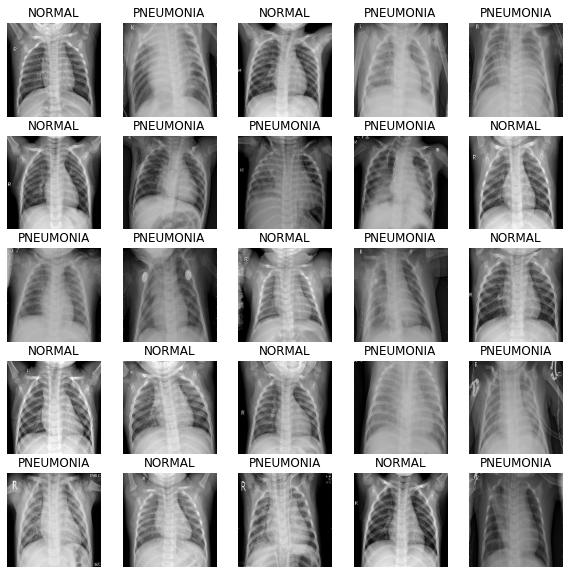

In [13]:
ShowBatch(25)